In [141]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
#allow me to scroll through dataframes without cutting out columns
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 

In [142]:
#Need to specify dtype of columns for every csv column for this and every other import

#the players number column, age, weight columns have NaN's in them probably can drop the number and weight columns
#as they are not features 
roster = pd.read_csv('stats_files/rosters', sep = '|')
#makes sure age matches this format and removes players which we don't have a birthdate for
#also excludes weird dates that might include dates over 31 or months over 12 or entries of 00
roster = roster[roster['Birthdate'].str.match('(\d\d\d\d)\-((?!00)0[1-9]|1[0-2])\-((?!00)(0[1-9]|[12]\d|3[01]))')]
#had two birthdates on september 31st just excluded them 
roster = roster[~roster['Birthdate'].str.match('(\d\d\d\d)\-09\-31')]

roster.shape

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136018, 13)

In [143]:
#Create the season start to calculate age at start of season for age adjusted statistics
roster['season_start'] = roster['season'].apply(lambda x: x - 1).apply('09-15-{}'.format)
roster['Birthdate'] = pd.to_datetime(roster['Birthdate'], format='%Y-%m-%d')
roster['season_start'] = pd.to_datetime(roster['season_start'], format='%m-%d-%Y')
roster['draft_cutoff'] = roster['season'].apply('09-15-{}'.format)
roster['draft_cutoff'] = pd.to_datetime(roster['draft_cutoff'], format='%m-%d-%Y')
#EP lists players Age as their current age instead of the age they were at the season
#I'm calculating their age as the age they are at the draft cutoff of that season
#in order to see if they are draft eligible that season. I have to calculate the players
#at sept. 15th of the draft year for that respective season. I then use that draft
#cutoff age to determine the years from their first draft eligible year
roster['Age'] = (roster['season_start'] - roster['Birthdate'])
roster['Age'] = roster['Age'] / timedelta(days=365.25)
roster['Age'] = roster['Age'].round(decimals=2)
roster['draft_cutoff_age'] = roster['draft_cutoff'] - roster['Birthdate']
roster['draft_cutoff_age'] = roster['draft_cutoff_age'] / timedelta(days=365.25)
roster['draft_cutoff_age'] = roster['draft_cutoff_age'].round(decimals=3)

In [144]:
#Remove goalies from the dataframe
roster = roster[roster['Position'] != 'G']
roster['Player'] = roster['Player'].str.strip()

In [145]:
#this function determines the years away from first draft eligible year for the season
#of the row i then apply it to the draft_cutoff_age column using pandas .apply() function
def draft_year(age):
    
    if age >=18 and age < 19:
        return 0
    else:
        return math.floor(age-18)
        
        
roster['draft_year'] = roster['draft_cutoff_age'].apply(draft_year)

In [146]:
#Join stats dataframe to the main roster dataframe
stats = pd.read_csv('stats_files/player_stats', sep='|')
stats['Player'] = stats['Player'].str.strip()
stats['team'] = stats['team'].str.strip()
stats = stats.groupby(['Player','season', 'team', 'team_id', 'player_id'], as_index=False).sum()

roster = roster.merge(stats[['player_id', 'season', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',  
                           'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'team_id', 'team']], 
                            on = ['player_id', 'season', 'team_id', 'team'])


In [147]:

#converting height into decimal values of feet
def clean_height(value):
    '''
    Function to convert height meausered in feet and inches to a decimal
    value
    Input:
    value - height measured in feet and inches
    Output:
    decimal_value - height returned in feet and inches converted to a decimal
                    value of feet
    '''
    try:
        value = value.replace("'", '.').replace(' ', '').replace('"', '')
        value_list = value.split('.')
        value_list[1] = float(value_list[1])/12
        value = float(value_list[0]) + value_list[1]
        value = round(value, 2)
    except IndexError as ex:
        value = ''

    return value

roster['HT'] = roster['HT'].astype('str').apply(clean_height)


In [148]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#create assist to total points ratios
roster['assists_to_points'] = roster['A']/roster['TP']
roster['assists_to_points'] = roster['assists_to_points'].fillna(value=0)
roster['assists_to_points'] = roster['assists_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [149]:
#joining league data to the dataframe
leagues_hist = pd.read_csv('stats_files/leagues_hist_table', sep='|')

roster = roster.merge(leagues_hist[['league', 'season', 'team_id']], on=['season', 'team_id'])

In [150]:
#reads in draft data and the NHL stats of each drafted player and then joins it to the 
#master dataframe
nhl_draft_data = pd.read_csv('stats_files/nhl_draft_stats', sep='|')

nhl_draft_data = nhl_draft_data.rename(index=str, columns={'G':'nhl_G', 'GP':'nhl_GP', 'A':'nhl_A', 'TP':'nhl_TP'})
roster = roster.merge(nhl_draft_data[['nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'player_id']], on=['player_id'],
                      how = 'left')
roster = roster.fillna(value=0)

In [151]:
roster.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,league,nhl_GP,nhl_G,nhl_A,nhl_TP
0,0,Tommy Albelin,38.32,D,1964-05-21,"Stockholm, SWE",6.08,194,L,701,80,2003,Albany River Rats,2002-09-15,2003-09-15,39.318,21,5,0,2,2,2,0,0,0,0,0,0,0.00,1.00,0.40,AHL,0.0,0,0,0
1,3,Daryl Andrews,25.39,D,1977-04-27,"Campbell River, BC, CAN",6.17,205,L,12221,80,2003,Albany River Rats,2002-09-15,2003-09-15,26.385,8,75,3,6,9,52,0,0,0,0,0,0,0.33,0.67,0.12,AHL,0.0,0,0,0
2,7,Alex Brooks,26.07,D,1976-08-21,"Madison, WI, USA",6.08,194,R,10257,80,2003,Albany River Rats,2002-09-15,2003-09-15,27.066,9,66,0,7,7,56,0,0,0,0,0,0,0.00,1.00,0.11,AHL,0.0,0,0,0
3,0,Phil Cole,20.02,D,1982-09-06,"Winnipeg, MB, CAN",6.33,196,L,15899,80,2003,Albany River Rats,2002-09-15,2003-09-15,21.024,3,4,0,0,0,6,0,0,0,0,0,0,0.00,0.00,0.00,AHL,0.0,0,0,0
4,28,Ray Giroux,26.15,D,1976-07-20,"North Bay, ON, CAN",6.08,190,L,12229,80,2003,Albany River Rats,2002-09-15,2003-09-15,27.154,9,67,11,38,49,49,0,0,0,0,0,0,0.22,0.78,0.73,AHL,0.0,0,0,0


In [152]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [153]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


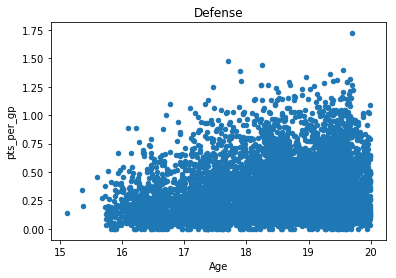

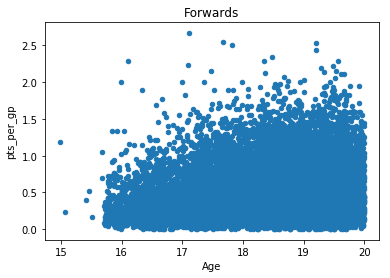

In [154]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

In [155]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)

fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)


In [156]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game since players older than 20 will be 
#artificially enhanced by age adjusted points
draft_year_df = roster[roster['draft_year'] == 0]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [157]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def['age_adj_pts_g'] = (1- ((draft_year_df_def['Age']-17) * def_model_coef)) \
                                        * draft_year_df_def['pts_per_gp']
draft_year_df_fwd['age_adj_pts_g'] = (1- ((draft_year_df_fwd['Age']-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

In [158]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [170]:
#Calculate NHL points per GP and fill NaN with zero for those that have zero NHL GP
draft_year_df.nhl_G = draft_year_df.nhl_G.astype('float')
draft_year_df.nhl_TP = draft_year_df.nhl_TP.astype('float')
draft_year_df.nhl_GP = draft_year_df.nhl_GP.astype('float')
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_TP'] / draft_year_df['nhl_GP']
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_pts_per_gp'].fillna(value=0)

In [186]:
draft_year_df = pd.get_dummies(draft_year_df, columns=['league'])

In [187]:
draft_year_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL
18094,6,Stefan Erkgärds,17.48,D,1985-03-23,IK Viking,6.08,192,L,622,25,2003,Bofors IK,2002-09-15,2003-09-15,18.480,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18390,2,Martin Vestberg,17.24,D,1985-06-20,Säters IF,5.92,209,L,2075,29,2003,Mora IK,2002-09-15,2003-09-15,18.237,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18541,16,Daniel Westerlund,17.88,D,1984-10-30,0,6.17,198,L,2205,19,2003,Team Kiruna,2002-09-15,2003-09-15,18.875,0,5,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18565,12,Erik Josefsson,17.01,D,1985-09-11,Tranås AIF,5.92,190,L,2217,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.010,0,8,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18567,28,Johan Magnusson,17.39,D,1985-04-24,Tranås AIF,6.17,220,L,956,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.393,0,35,0,0,0,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [188]:
#split draft_year_df into one for forwards and defensemen
draft_df_fwd = draft_year_df[draft_year_df['Position'] != 'D']
draft_df_def = draft_year_df[draft_year_df['Position'] == 'D']

In [189]:
#Determine Forward quartile buckets for GP and pts per game
draft_df_fwd[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .95, .96, .97, .98, .99])

,GP,nhl_pts_per_gp
0.25,15.0,0.000000
0.50,42.0,0.000000
0.75,60.0,0.000000
0.95,69.0,0.264989
0.96,70.0,0.322927
0.97,71.0,0.396638
0.98,72.0,0.508132
0.99,72.0,0.672472


In [190]:
#Determine Defense quartile buckets for GP and pts per game
draft_df_def[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .99])

,GP,nhl_pts_per_gp
0.25,14.0,0.000000
0.50,39.0,0.000000
0.75,58.0,0.000000
0.99,72.0,0.443006


In [194]:
draft_df_def['>_39_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=39) & (draft_df_def['nhl_GP'] < 58), 1, 0)
draft_df_def['>_58_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=58) & (draft_df_def['nhl_GP'] < 72), 1, 0)
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)

In [196]:
draft_df_def.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_39_nhl_gp,>_58_nhl_gp,>_72_nhl_gp
18094,6,Stefan Erkgärds,17.48,D,1985-03-23,IK Viking,6.08,192,L,622,25,2003,Bofors IK,2002-09-15,2003-09-15,18.480,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18390,2,Martin Vestberg,17.24,D,1985-06-20,Säters IF,5.92,209,L,2075,29,2003,Mora IK,2002-09-15,2003-09-15,18.237,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18541,16,Daniel Westerlund,17.88,D,1984-10-30,0,6.17,198,L,2205,19,2003,Team Kiruna,2002-09-15,2003-09-15,18.875,0,5,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18565,12,Erik Josefsson,17.01,D,1985-09-11,Tranås AIF,5.92,190,L,2217,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.010,0,8,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18567,28,Johan Magnusson,17.39,D,1985-04-24,Tranås AIF,6.17,220,L,956,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.393,0,35,0,0,0,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [193]:
draft_df_fwd.columns

Index(['#', 'Player', 'Age', 'Position', 'Birthdate', 'Birthplace', 'HT', 'WT',
       'Shots', 'player_id', 'team_id', 'season', 'team', 'season_start',
       'draft_cutoff', 'draft_cutoff_age', 'draft_year', 'GP', 'G', 'A', 'TP',
       'PIM', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
       'playoff_PIM', 'playoff_+/-', 'goals_to_points', 'assists_to_points',
       'pts_per_gp', 'nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'age_adj_pts_g',
       'nhl_pts_per_gp', 'league_Allsvenskan', 'league_Extraliga',
       'league_KHL', 'league_Liiga', 'league_Mestis', 'league_NCAA',
       'league_OHL', 'league_QMJHL', 'league_SHL', 'league_USDP',
       'league_USHL', 'league_WHL'],
      dtype='object')

In [204]:
draft_df_def[['GP', 'playoff_GP', 'playoff_G', 'playoff_A', 
             'playoff_TP', 'playoff_+/-',
             'goals_to_points', 'assists_to_points',
             'age_adj_pts_g', 'league_Allsvenskan', 
             'league_Extraliga','league_KHL', 'league_Liiga', 
             'league_Mestis', 'league_NCAA', 'league_OHL', 
             'league_QMJHL', 'league_SHL', 'league_USDP', 
             'league_USHL', 'league_WHL', '>_39_nhl_gp']].corr()

,GP,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_+/-,goals_to_points,assists_to_points,age_adj_pts_g,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_39_nhl_gp
GP,1.000000,0.498794,0.279784,0.342421,0.351519,-0.012190,0.297524,0.542235,0.386863,-0.197702,-0.159734,-0.104676,-0.109545,-0.115668,-0.022766,0.123668,0.034541,-0.176546,0.018789,-0.080857,0.184560,0.056905
playoff_GP,0.498794,1.000000,0.517245,0.660123,0.671082,0.222205,0.153996,0.241376,0.303137,-0.072936,-0.069199,-0.055092,-0.046973,-0.040235,-0.065308,0.086781,0.063364,-0.051300,-0.034518,-0.108145,0.065083,0.042210
playoff_G,0.279784,0.517245,1.000000,0.638466,0.797694,0.205316,0.108289,0.102822,0.404463,-0.035086,-0.038411,-0.025028,-0.030707,-0.021152,-0.028934,0.053028,0.025030,-0.040809,-0.015293,-0.046625,0.029982,0.064794
playoff_A,0.342421,0.660123,0.638466,1.000000,0.973448,0.302859,0.106491,0.139838,0.468217,-0.051514,-0.038959,-0.030419,-0.021306,-0.023079,-0.035166,0.076224,0.039664,-0.050392,-0.018587,-0.061487,0.017445,0.076173
playoff_TP,0.351519,0.671082,0.797694,0.973448,1.000000,0.298372,0.115649,0.140152,0.487169,-0.050799,-0.041951,-0.031279,-0.025827,-0.024375,-0.036160,0.075497,0.038524,-0.051622,-0.019112,-0.062046,0.022586,0.078957
playoff_+/-,-0.012190,0.222205,0.205316,0.302859,0.298372,1.000000,-0.007938,-0.003045,0.030451,0.014351,0.010084,0.003206,0.008147,-0.003092,0.005408,-0.004454,-0.020263,0.001457,0.002858,0.035664,-0.019157,0.010665
goals_to_points,0.297524,0.153996,0.108289,0.106491,0.115649,-0.007938,1.000000,-0.085492,0.247482,-0.062672,-0.089311,-0.043492,-0.046759,-0.034141,0.028274,-0.002816,0.007535,-0.064454,-0.002256,0.070004,0.033050,0.025427
assists_to_points,0.542235,0.241376,0.102822,0.139838,0.140152,-0.003045,-0.085492,1.000000,0.386843,-0.175373,-0.153387,-0.090250,-0.094966,-0.068745,0.014628,0.108533,0.000537,-0.162379,0.029823,0.024302,0.099727,0.010157
age_adj_pts_g,0.386863,0.303137,0.404463,0.468217,0.487169,0.030451,0.247482,0.386843,1.000000,-0.101220,-0.104047,-0.063156,-0.055191,-0.024683,0.049478,0.055231,-0.015612,-0.106009,0.063289,0.072154,0.024143,0.085257
league_Allsvenskan,-0.197702,-0.072936,-0.035086,-0.051514,-0.050799,0.014351,-0.062672,-0.175373,-0.101220,1.000000,-0.023574,-0.015360,-0.018846,-0.018309,-0.017757,-0.101342,-0.100025,-0.031382,-0.009386,-0.081265,-0.106602,-0.014362


In [197]:
#Splitting the data into 80/20 train test split with playing more than 50 games as the feature to predict 
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(draft_df_def[['GP', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 'league_USDP', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_def['>_39_nhl_gp'], test_size=0.2)

In [198]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2742, 21) (2742,)
(686, 21) (686,)


In [199]:
#train the logistic regression
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [179]:
#get probability scores for each player playing over 50 games in NHL
predictions = logisticRegr.predict_proba(X_test)[:,1]


In [180]:
predict = logisticRegr.predict(X_test)

In [163]:
import matplotlib.pyplot as plt
plt.scatter(y_test, predict)
logisticRegr.score(X_test, y_test)

NameError: name 'y_test' is not defined

In [182]:
predictions_2018 = logisticRegr.predict_proba(draft_2018_df[['GP', 'G', 'A', 'TP',
                                                             'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
            
                                                             'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']])[:,1]
predictions = logisticRegr.predict_proba(draft_year_df[['GP', 'G', 'A', 'TP',
                                                             'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
            
                                                             'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']])[:,1]

In [183]:
draft_2018_df['>_.25_game_probs'] = predictions_2018
draft_year_df['>_.25_game_probs'] = predictions


Text(0.5,0,'NHL GP')

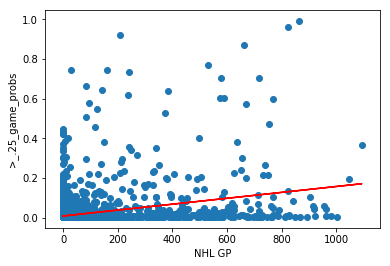

In [185]:
fig, ax = plt.subplots()
fit = np.polyfit(draft_year_df['nhl_GP'], draft_year_df['>_.25_game_probs'], deg=1)
ax.plot(draft_year_df['nhl_GP'], fit[0] * draft_year_df['nhl_GP'] + fit[1], color='red')
ax.scatter(draft_year_df['nhl_GP'], draft_year_df['>_.25_game_probs'])
plt.ylabel('>_.25_game_probs')
plt.xlabel('NHL GP')

In [187]:
draft_year_df = draft_year_df.sort_values(['>_.25_game_probs'], ascending=False)

In [189]:
draft_year_df[['Player', '>_.25_game_probs']].head(20)

,Player,>_.25_game_probs
89502,Sidney Crosby,0.992933
81643,Patrick Kane,0.961034
86037,Connor McDavid,0.922012
82478,Steven Stamkos,0.868355
83668,Taylor Hall,0.769975
86151,Mitchell Marner,0.746515
86041,Dylan Strome,0.742898
93846,Jonathan Drouin,0.735239
89779,Derick Brassard,0.703936
83310,Jeff Skinner,0.701914


In [190]:
draft_year_df[draft_year_df['Player']=='Nicklas Bäckström']

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,...,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,nhl_pts_per_gp,50_plus_nhl_gp,>_than_.25_pts_gp,>_.25_game_probs
98124,19,Nicklas Bäckström,17.81,C,1987-11-23,Valbo AIF,6,214,L,3682,...,209.0,590,799,0.38,0.57,0.5266,0.256442,1,1,0.008003


In [194]:
draft_2018_df[['Player', '>_.25_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['>_.25_game_probs'], ascending=False).iloc[:50,:]

,Player,>_.25_game_probs
34,Andrei Svechnikov,0.446119
191,Filip Zadina,0.371219
415,Oliver Wahlstrom,0.300902
264,Joel Farabee,0.095312
228,Jack Drury,0.072660
182,Evan Bouchard,0.068338
13,Aidan Dudas,0.059805
276,Joseph Veleno,0.059653
17,Akil Thomas,0.057928
269,Johnny Gruden,0.054439


In [196]:
draft_rankings_2018 = draft_2018_df[['Player', '>_.25_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['>_.25_game_probs'], ascending=False)

In [197]:
draft_rankings_2018[(draft_rankings_2018['Player']=='Brady Tkachuk')]

,Player,>_.25_game_probs
67,Brady Tkachuk,0.010608
